In [10]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# B-Score: Open Script for IEEE Publication 

This is the complementary code scripz section for the B-Score Paper published in the IEEE Biomedical and Health Informatics Journal. It is an Open Source script available under the GNU General Public License:

    Copyright (C) 2021  Tomas L Bothe

    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>

    Author contact information:
    Tomas L Bothe
    tomas-lucca.bothe@charite.de


Link to the Github Repository:


# Functionality

This script allows you to analyse your BP estimation dataset and calculate the base performances needed for B-Score calculation. If you choose to provide your T-RMSE value, this script will directly allow you to calculate your model's B-Score.

# How to use:
Cells containing necessary imports or utility functions are collapsed. Please run them by pressing Shift + ENTER.

Cells containing optional functionality will be highlighted by explanatory texts beforehand.
If you wish to inspect the code double click on collapsed cells to expand them.



In [11]:
#@title Import necessary libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import preprocessing
from sklearn.model_selection import GroupShuffleSplit
from sklearn_pandas import DataFrameMapper
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import RootMeanSquaredError

In [12]:
#@title Import utility functions


# Strips Dataframe of all unused columns
def prep_df(df, handles):

  df = df[handles]
  return df


# Definition DL-Basemodel 
def get_model(input_shape):

  model = Sequential([
                      Dense(8, activation = 'relu', input_shape = input_shape),
                      BatchNormalization(),
                      Dense(6, activation = 'relu'),
                      BatchNormalization(),
                      Dense(4, activation = 'relu'),
                      BatchNormalization(),
                      Dense(3, activation = 'relu'),
                      BatchNormalization(),
                      Dense(1)
  ])
  return model


# Function for training model and saving best iteration
def train_model(model, X_train, y_train, X_val, y_val, savepath):

  ES = EarlyStopping(monitor = 'val_RMSE', patience = 10, verbose = 2)
  RedLR = ReduceLROnPlateau(monitor = 'loss',
                            factor = 0.1,
                            patience = 2,
                            verbose = 0)
   
  Checkpoint = ModelCheckpoint(filepath = savepath,
                             monitor = 'val_RMSE',
                             verbose = 0,
                             save_freq = 'epoch',
                             save_best_only = True,
                             save_weights_only = True)
  
  history = model.fit(X_train, y_train, validation_data = (X_val, y_val),
                    batch_size = 256,
                    epochs = 10000,
                    verbose = 0,
                    callbacks = [ES, RedLR, Checkpoint],
                    shuffle = True)
  

# Function for plotting k-fold evaluation results
# Add None as T_RMSE if you wish to not provide your model's performance
def plot_k_fold_results(B1_RMSE, B2_RMSE, M_RMSE, BP_type,
                         T_RMSE = None, picture_savepath = None,
                         dpi_chosen = 100,
                         B1_Score = None,
                         B2_Score = None,
                         B_Score = None):

  if B_Score != None:
    B1_str = str(round(B1_Score, 3))
    B2_str = str(round(B2_Score, 3))
    B_str = str(round(B_Score, 3))
  B1_R_str = str(round(B1_RMSE, 3)) 
  B2_R_str = str(round(B2_RMSE, 3))
  M_R_str = str(round(M_RMSE, 3))
  
  if T_RMSE != None:
    width = 0.7
    labels = ['B1', 'B2', 'M', 'T']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    values = [B1_RMSE, B2_RMSE, M_RMSE, 4.0]
    x = np.arange(len(values))
    Bar = ax1.bar(x,
                  values,
                  width,
                  color = ['royalblue','cornflowerblue','limegreen','tomato'])
    
    if B_Score != None:

      a = 'Your model\'s B-Score is:   ' + B_str
      b = '\n\nYour model\'s B1-Score is: ' + B1_str
      c = '\nYour model\'s B2-Score is: ' + B2_str
      d = '\n\n\nYour model\'s B1-RMSE is: ' + B1_R_str
      e = '\nYour model\'s B2-RMSE is: ' + B2_R_str
      f = '\nYour model\'s M-RMSE is:  ' + M_R_str
      text = a + b + c + d + e + f
      ax2.text(0, 0.45, text, fontsize = 13)
      if BP_type == 'SBP':
        ax1.set_title('SBP RMSE and B-Scores')
      else:
        ax1.set_title('DBP RMSE and B-Scores')

    ax2.axis('off')
    if BP_type == 'SBP':
        ax1.set_title('SBP RMSE')
    else:
        ax1.set_title('DBP RMSE')
    

  else:
    width = 0.7
    labels = ['B1', 'B2', 'M']
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
    values = [B1_RMSE, B2_RMSE, M_RMSE]
    x = np.arange(len(values))
    Bar = ax1.bar(x,
                  values,
                  width,
                  color = ['royalblue','cornflowerblue','limegreen'])
    a = '\n\n\nYour model\'s B1-RMSE is: ' + B1_R_str
    b = '\nYour model\'s B2-RMSE is: ' + B2_R_str
    c = '\nYour model\'s M-RMSE is:  ' + M_R_str
    text = a + b + c 
    ax2.text(0, 0.45, text, fontsize = 13)
    ax2.axis('off')
    if BP_type == 'SBP':
        ax1.set_title('SBP RMSE')
    else:
        ax1.set_title('DBP RMSE')

  ax1.set_ylabel('RMSE')
  ax1.set_xticks(x)
  ax1.set_xticklabels(labels) 
  
  
  

  if picture_savepath != None:
    if BP_type == 'SBP':
      picture_savepath = picture_savepath + 'SBP_results'
    else:
      picture_savepath = picture_savepath + 'DBP_results'
    fig.savefig(picture_savepath, dpi = dpi_chosen)



# Calculate B-Score
def calculate_B_Scores(B1, B2, M, T):

  B1_Score = np.log10(B1 * M / (T * T))
  B2_Score = np.log10(B2 * M / (T * T))
  B_Score = np.log10(np.sqrt((B1 * M / (T * T)) * (B2 * M / (T * T))))
  return (B1_Score, B2_Score, B_Score)



# K-fold evaluation
def k_fold_evaluation(df, num_splits, handles,
                      savepath, BP_type, T_RMSE = None):

  start = time.time()
  
  test_handle = handles.pop(-1)
  id_handle = handles[0]
  cal_handle = handles[-1]
  train_handle = handles[1 : ]
  train_handle.append('Cohort_Mean')
  del handles

  ids = df[id_handle].unique()
  np.random.shuffle(ids)
  k_ids = np.array_split(ids, num_splits)
  df_list = []

  for i in range(num_splits):

    df_new = df[df[id_handle].isin(k_ids[i])]
    df_list.append(df_new)
    del df_new


  B1_RMSE_list = []
  B2_RMSE_list = []
  M_RMSE_list = []
  df_train_shape_list = []


  print('\n\nk-fold evaluation starts')
  print('Please do not interrupt the program')
  print('Depending on your machine this process may take a while\n\n')
  for i in range(num_splits):

    i_start = time.time()
    df_test = df_list.pop(0)
    df_val = df_list[0]
    df_train = pd.concat(df_list[1 :])
    df_list.append(df_test)
    df_train_shape_list.append(df_train.shape[0])

    Cohort_Mean = df_train[test_handle].mean()
    df_train['Cohort_Mean'] = Cohort_Mean
    df_val['Cohort_Mean'] = Cohort_Mean
    df_test['Cohort_Mean'] = Cohort_Mean

    # Get B1-RMSE and B2-RMSE and append them to list
    B1_RMSE = mean_squared_error(df_test[test_handle],
                                 df_test['Cohort_Mean'],
                                 squared = False)
    B1_RMSE_list.append(B1_RMSE)
    B2_RMSE = mean_squared_error(df_test[test_handle],
                                 df_test[cal_handle],
                                 squared = False)
    B2_RMSE_list.append(B2_RMSE)

    # Split into X and y datasets
    X_train = df_train[train_handle]
    y_train = df_train[test_handle]
    X_val = df_val[train_handle]
    y_val = df_val[test_handle]
    X_test = df_test[train_handle]
    y_test = df_test[test_handle]

    # Normalize X on X_train
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)

    del df_train
    del df_val
    del df_test

    # Get, compile and train model
    model = get_model(X_train[1].shape)
    model.compile(optimizer = 'Adam',
                  loss = 'mse',
                  metrics = [RootMeanSquaredError(name = 'RMSE')])
    train_model(model, X_train, y_train, X_val, y_val, savepath)

    # Reload best model
    model.load_weights(savepath)

    # Get M_RMSE and append to list
    M = model.evaluate(X_test, y_test, batch_size = 4096)[1]
    M_RMSE_list.append(M)

    i_end = time.time()
    i_time = (i_end - i_start) / 60
    print('\nTime for iteration %d: %d minutes\n\n'%(i+1, i_time))

  
  B1_avg = sum(B1_RMSE_list) / len(B1_RMSE_list)
  B2_avg = sum(B2_RMSE_list) / len(B2_RMSE_list)
  M_avg = sum(M_RMSE_list) / len(M_RMSE_list)
  T_avg = T_RMSE

  B1_Score = None
  B2_Score = None
  B_Score = None
  
  if T_avg != None:
    scores = calculate_B_Scores(B1_avg, B2_avg, M_avg, T_avg)
    B1_Score = scores[0]
    B2_Score = scores[1]
    B_Score = scores[2]
    del scores  


  if B_Score != None:
    plot_k_fold_results(B1_avg, B2_avg, M_avg,
                        BP_type,
                        T_avg,
                        None,
                        None,
                        B1_Score, B2_Score, B_Score)
  else:
    plot_k_fold_results(B1_avg, B2_avg, M_avg, BP_type, T_avg)

  end = time.time()
  total_time = (end - start) / 60
  print('\n\nTotal computation time: %4d minutes'%(total_time))

  if T_avg != None: 
    print('\n\n\n\nYour model\'s B1-Score is: {0}'.format(B1_Score))
    print('Your model\'s B2-Score is: {0}'.format(B2_Score))
    print('\nYour model\'s B-Score is: {0}'.format(B_Score))

  return B1_avg, B2_avg, M_avg, T_avg, B1_Score, B2_Score, B_Score

  

# Circularize Time and Cal_Time (sin / cos transformation)
def time_circularization(df):
  df[Measurement_time] = pd.to_timedelta(df[Measurement_time])
  df[Measurement_time] = df[Measurement_time].dt.total_seconds()
  df[Calibration_time] = pd.to_timedelta(df[Calibration_time])
  df[Calibration_time] = df[Calibration_time].dt.total_seconds()

  df['Time_sin'] = np.sin(2 * np.pi * df[Measurement_time] / 86400)
  df['Time_cos'] = np.cos(2 * np.pi * df[Measurement_time] / 86400)
  df['Cal_Time_sin'] = np.sin(2 * np.pi * df[Calibration_time] / 86400)
  df['Cal_Time_cos'] = np.cos(2 * np.pi * df[Calibration_time] / 86400)
  return df








# Upload your dataset

Insert the file path to your dataset in the parentheses below. Note that the filepath has to end in a .csv file. Please also select a savepath needed for the evaluation model.

In [13]:
# Load Dataset

#filepath = 'Insert your .csv filepath here'
filepath = '/content/gdrive/MyDrive/Colab Notebooks/Univ_Data/MIMIC 3/SBP_Analysis_ready.csv'
#savepath = 'Insert your model savepath here'
savepath = '/content/gdrive/MyDrive/Colab Notebooks/Univ_Data/MIMIC 3/Models'

In [14]:
#@title Inspect your dataset

df = pd.read_csv(filepath,
                 index_col = 0)
df.head(5)


,stay_id,Time,Cal_Time,Sex,anchor_age,Time_sin,Time_cos,Cal_Time_sin,Cal_Time_cos,24_Cal,Cal_HR,HR,SBP,Individual_Var,Rank
0,34100191,17:16:00,17:00:00,1,47,-0.981627,-1.908090e-01,-0.965926,-0.258819,112,134.0,144,123,165.059342,36.910514
1,34100191,17:48:00,17:00:00,1,47,-0.998630,-5.233596e-02,-0.965926,-0.258819,112,134.0,133,114,165.059342,36.910514
2,34100191,18:00:00,17:00:00,1,47,-1.000000,-1.836970e-16,-0.965926,-0.258819,112,134.0,124,104,165.059342,36.910514
3,34100191,19:00:00,17:00:00,1,47,-0.965926,2.588190e-01,-0.965926,-0.258819,112,134.0,113,96,165.059342,36.910514
4,34100191,20:00:00,17:00:00,1,47,-0.866025,5.000000e-01,-0.965926,-0.258819,112,134.0,105,95,165.059342,36.910514


In [15]:
df.drop(['Time_sin', 'Time_cos', 'Cal_Time_sin', 'Cal_Time_cos'], axis = 1, inplace = True)

# Define column handles

Please provide the column handles for **your** dataset below as they are shown in your dataset above. Write the handles inside the provided paratheses. If you are promted to set the variable to NONE, please do so **without** the parentheses. It is assumed that you dataset already has calibration times and values. If this is not the case, please revisit the B-Score publication for further information. 

Your measurement and calibration time values will be sine / cosine transformed if they have not been already. Please provide **either** two column handles for uncircularized times or four column handles for circularized times.

Set the ground truth variable (reference blood pressure value) to **either** SBP or DBP values. Please remark that systolic and diastolic performance can only be evaluated seperately. Please set the BP-type variable to **either** 'SBP' or 'DBP'.

In [10]:
# Please provide the column handles for your dataset:

ID = 'stay_id'
Sex = 'Sex'
Age = 'anchor_age'
Heart_Rate = 'HR'
Calibration_Heart_Rate = 'Cal_HR'
Calibration_BP = '24_Cal'


# Please provide the column handles for either measurement and calibration
# time values OR four the four circularized time values:

Measurement_time = None
Calibration_time = None
# OR
Measurement_time_sin = 'Time_sin'
Measurement_time_cos = 'Time_cos'
Calibration_time_sin = 'Cal_Time_sin'
Calibration_time_cos = 'Cal_Time_cos'


# Please provide the ground truth label and the BP-type:

Ground_truth = 'SBP'
BP_type = 'SBP'

In [17]:
# Please provide the column handles for your dataset:

ID = 'stay_id'
Sex = 'Sex'
Age = 'anchor_age'
Heart_Rate = 'HR'
Calibration_Heart_Rate = 'Cal_HR'
Calibration_BP = '24_Cal'


# Please provide the column handles for either measurement and calibration
# time values OR for the four circularized time values:

Measurement_time = 'Time'
Calibration_time = 'Cal_Time'
# OR
Measurement_time_sin = None
Measurement_time_cos = None
Calibration_time_sin = None
Calibration_time_cos = None


# Please provide the ground truth label and the BP-type:

Ground_truth = 'SBP'
BP_type = 'SBP'

In [ ]:
# Please provide the column handles for your dataset:

ID = 'Insert handle here'
Sex = 'Insert handle here'
Age = 'Insert handle here'
Heart_Rate = 'Insert handle here'
Calibration_Heart_Rate = 'Insert handle here'
Calibration_BP = 'Insert handle here'


# Please provide the column handles for either measurement and calibration
# time values OR four the four circularized time values:

Measurement_time = 'Insert handle here OR set to NONE'
Calibration_time = 'Insert handle here OR set to NONE'
# OR
Measurement_time_sin = 'Insert handle here OR insert NONE'
Measurement_time_cos = 'Insert handle here OR insert NONE'
Calibration_time_sin = 'Insert handle here OR insert NONE'
Calibration_time_cos = 'Insert handle here OR insert NONE'


# Please provide the ground truth label and the BP-type:

Ground_truth = 'Insert handle here'
BP-type = 'Set to SBP OR DBP'

In [18]:
#@title Dataset handles and time circularization

handles = []
handles.append(ID)
handles.append(Sex)
handles.append(Age)
handles.append(Heart_Rate)
handles.append(Calibration_Heart_Rate)


if Measurement_time != None and Calibration_time != None:
  df = time_circularization(df)
  handles.append('Time_sin')
  handles.append('Time_cos')
  handles.append('Cal_Time_sin')
  handles.append('Cal_Time_cos')

else:
  handles.append(Measurement_time_sin)
  handles.append(Measurement_time_cos)
  handles.append(Calibration_time_sin)
  handles.append(Calibration_time_cos)

handles.append(Ground_truth)
handles.append(Calibration_BP)
df = prep_df(df, handles)

In [19]:
#@title Inspect your dataset

df.head(5)

,stay_id,Sex,anchor_age,HR,Cal_HR,Time_sin,Time_cos,Cal_Time_sin,Cal_Time_cos,SBP,24_Cal
0,34100191,1,47,144,134.0,-0.981627,-1.908090e-01,-0.965926,-0.258819,123,112
1,34100191,1,47,133,134.0,-0.998630,-5.233596e-02,-0.965926,-0.258819,114,112
2,34100191,1,47,124,134.0,-1.000000,-1.836970e-16,-0.965926,-0.258819,104,112
3,34100191,1,47,113,134.0,-0.965926,2.588190e-01,-0.965926,-0.258819,96,112
4,34100191,1,47,105,134.0,-0.866025,5.000000e-01,-0.965926,-0.258819,95,112


# K-fold evaluation

After dataset preparation the following cell will load and run the k-fold (ten-fold) evaluation process. Please note that this may take a while, depending on the chosen dataset size and your machine's computational capacities. After each of the the k-fold iterations a visual printout will indicate the progress.

You can set your own T-RMSE if wanted. If you do not wish to provide a T-RMSE value, please set the variable to NONE.

In [20]:
# Please set your T-RMSE in the X.y format. If you do not wish to provide a 
# T-RMSE value please set the variable to NONE. 

T_RMSE = 4.0



k-fold evaluation starts
Please do not interrupt the program
Depending on your machine this process may take a while


Epoch 00025: early stopping
191/191 [==============================] - 0s 2ms/step - loss: 365.8293 - RMSE: 19.1267

Time for iteration 1: 3 minutes


Epoch 00028: early stopping
186/186 [==============================] - 0s 2ms/step - loss: 362.9666 - RMSE: 19.0517

Time for iteration 2: 3 minutes


Epoch 00023: early stopping
187/187 [==============================] - 0s 2ms/step - loss: 359.7620 - RMSE: 18.9674

Time for iteration 3: 3 minutes




Total computation time:   10 minutes




Your model's B1-Score is: 1.442604935487708
Your model's B2-Score is: 1.4175641078638708

Your model's B-Score is: 1.4300845216757894


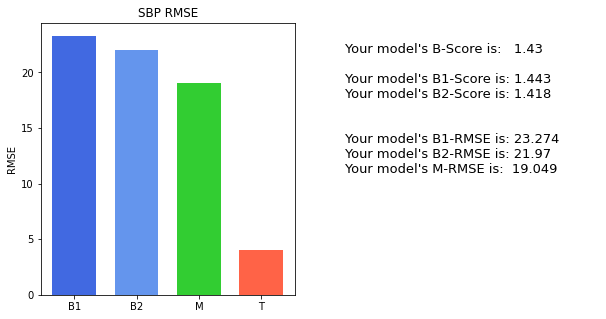

In [21]:
#@title Run k-fold evaluation

B1_avg, B2_avg, M_avg, T_avg, B1_Score, B2_Score, B_Score = k_fold_evaluation(
                                                  df = df,
                                                  num_splits = 3,
                                                  handles = handles,
                                                  T_RMSE = T_RMSE,
                                                  savepath = savepath,
                                                  BP_type = BP_type)

# Save your results

You can save your results in the .png picture format.

Please provide a filepath to which the picture should be saved below. The files will be saved with specified handles of SBP and DBP respectively.

You can also specify the pictures resolution by changing the dots per inch (DPI) value. The default DPI value is 100. Increasing the value may lead to longer processing times.

In [22]:
#picture_filepath = 'Insert your picture savepath here'
picture_filepath = '/content/gdrive/MyDrive/Colab Notebooks/Univ_Data/MIMIC 3/'

DPI = 100

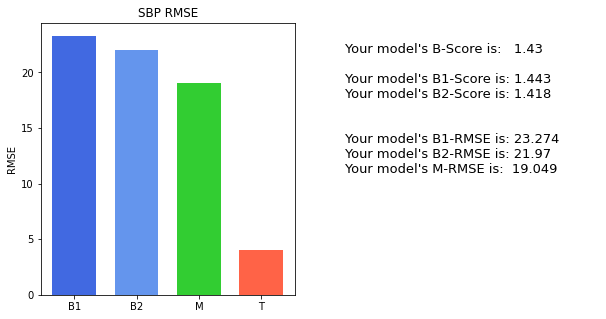

In [23]:
#@title Save results as .png

plot_k_fold_results(B1_avg, B2_avg, M_avg, BP_type, T_avg,
                    picture_filepath, DPI, B1_Score, B2_Score, B_Score)

# Thank you!

Thank you for using the complementary B-Score calculation script. We are looking forward to see your publication and your B-Score results.

To reuse the script (e.g. for DBP values) reload the complete script and again go through it step by step.